In [2]:
import pandas as pd
import numpy as np
def setup_scmamp_rpy2():
    import warnings
    warnings.filterwarnings('ignore')
    import rpy2
    import rpy2.robjects as robjects
    import rpy2.robjects.packages as rpackages
    from rpy2.robjects.vectors import StrVector
    from rpy2.robjects.packages import importr, data
    from rpy2.robjects import r, pandas2ri
    pandas2ri.activate();

    rpy2.robjects.r['options'](warn=-1)
    install_packages = False
    utils = rpackages.importr('utils')
    utils.chooseCRANmirror(ind=1)
    #utils.install_packages('rlang');
    if install_packages:
        utils = rpackages.importr('utils')
        utils.chooseCRANmirror(ind=1)
        packnames = ('scmamp', 'BiocManager')

        names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
        if len(names_to_install) > 0:
            utils.install_packages(StrVector(names_to_install))

        biocmanager = rpackages.importr('BiocManager')
        biocmanager.install('Rgraphviz')
        biocmanager.install('graph')

    scmamp = rpackages.importr('scmamp')


"""
def compute_scmamp_cem(data_df):
    import rpy2.robjects.packages as rpackages
    scmamp = rpackages.importr('scmamp')
    cem_res = scmamp.contrastEstimationMatrix(data_df)
    cem_df = pd.DataFrame(cem_res, columns=data_df.columns, index=data_df.columns)
    return cem_df
"""

"""
    Computes contrast estimation based on medians in 4 steps as described in:
    Garcia et al. 2010 https://sci2s.ugr.es/sites/default/files/files/TematicWebSites/sicidm/2010-Garcia-INS.pdf
    see pages 6-8
"""
def garcia_2010_cem(data_df):
    # perform steps 1 and 2 of computing Zuv matrix
    num_algorithms = data_df.columns.shape[0]
    algorithm_names = data_df.columns.tolist()
    Zuv_matrix = pd.DataFrame(data=np.zeros(shape=(num_algorithms, num_algorithms)),
                              columns=algorithm_names,
                              index=algorithm_names)
    
    for u_idx in range(num_algorithms):
        for v_idx in range(u_idx+1, num_algorithms):
            u = algorithm_names[u_idx]
            v = algorithm_names[v_idx]
            
            tmp_df = data_df[[u, v]].copy()
            tmp_df = tmp_df.dropna(axis=0)
            u_arr = tmp_df[u].values 
            v_arr = tmp_df[v].values

            # get difference vector of strategies u and v
            perf_diff = u_arr - v_arr

            # get median differences
            median_diff = np.median(perf_diff)
            
            # save to Zuv matrix
            Zuv_matrix.loc[u,v] = median_diff
            Zuv_matrix.loc[v,u] = -median_diff
            
    # step 3 compute mean of median differens
    mean_medians_diff = Zuv_matrix.mean(axis=1)

    # step 4 compute difference of strategy u and v
    cem_matrix = pd.DataFrame(data=np.zeros(shape=(num_algorithms, num_algorithms)),
                              columns=algorithm_names,
                              index=algorithm_names)
    for u_idx in range(num_algorithms):
        for v_idx in range(u_idx+1, num_algorithms):
            u = algorithm_names[u_idx]
            v = algorithm_names[v_idx]
            u_val = mean_medians_diff.loc[u]
            v_val = mean_medians_diff.loc[v]

            # save to Zuv matrix
            cem_matrix.loc[u,v] = u_val - v_val
            cem_matrix.loc[v,u] = v_val - u_val
            
    return cem_matrix, Zuv_matrix, mean_medians_diff

index = ['Adult','Breast','Bupa','Car','Cleveland','Contraceptive','Dermatology','Ecoli','German',
         'Glass','Haberman','Iris','Lymphography','Mushrooms','Newthyroid','Penbased',
         'Ring','Satimage','Shuttle','Spambase', 'Thyroid','Vehicle','Wine', 'Wisconsin']

columns = ['PDFC (1)', 'NNEP (2)', 'IS-CHC + 1NN (3)', 'FH-GBML (4)']
    
data_df = [[0.752,0.773,0.785, 0.795],
          [0.727,0.748,0.724,0.713],
          [0.736,0.716,0.585,0.638],
          [0.994, 0.861, 0.880, 0.791],
          [ 0.508, 0.553, 0.575, 0.515],
          [ 0.535, 0.536, 0.513, 0.471],
          [0.967, 0.871 ,0.954 , 0.532],
          [0.831, 0.807,0.819, 0.768],
          [0.745, 0.702,0.719, 0.705],
          [0.709, 0.572 , 0.669, 0.607],
          [0.722, 0.728, 0.725, 0.732],
          [ 0.967, 0.947 , 0.953, 0.960],
          [0.832, 0.752 , 0.802, 0.691],
          [0.998, 0.992 , 0.482, 0.910],
          [0.963, 0.963, 0.954, 0.926],
          [0.982, 0.953, 0.932, 0.630],
          [0.978, 0.773, 0.834, 0.849],
          [0.854, 0.787, 0.841, 0.779],
          [0.965, 0.984, 0.995, 0.947],
          [0.924, 0.887 ,0.861, 0.804],
          [0.929, 0.942, 0.931, 0.921],
          [0.837, 0.643,0.602, 0.554],
          [0.972, 0.956, 0.944, 0.922],
          [0.958, 0.959,0.964, 0.964]]

data_df = pd.DataFrame(data=data_df,
                       columns=columns,
                       index=index)

#setup_scmamp_rpy2()

In [5]:
cem1, Zuv_matrix, mean_medians_diff = garcia_2010_cem(data_df)
#cem2 = compute_scmamp_cem(data_df)

In [6]:
cem1

,PDFC (1),NNEP (2),IS-CHC + 1NN (3),FH-GBML (4)
PDFC (1),0.00000,0.02250,0.01975,0.05925
NNEP (2),-0.02250,0.00000,-0.00275,0.03675
IS-CHC + 1NN (3),-0.01975,0.00275,0.00000,0.03950
FH-GBML (4),-0.05925,-0.03675,-0.03950,0.00000


In [12]:
cem2

,PDFC,NNEP,IS-CHC + 1NN,FH-GBML
PDFC,0.00000,0.02250,0.01975,0.05925
NNEP,-0.02250,0.00000,-0.00275,0.03675
IS-CHC + 1NN,-0.01975,0.00275,0.00000,0.03950
FH-GBML,-0.05925,-0.03675,-0.03950,0.00000


In [13]:
np.array_equal(cem1, cem2)

True

In [7]:
cem_matrix, Zuv_matrix, mean_medians_diff = garcia_2010_cem(data_df)

In [23]:
print(Zuv_matrix.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  PDFC (1) &  NNEP (2) &  IS-CHC + 1NN (3) &  FH-GBML (4) \\
\midrule
PDFC (1)         &    0.0000 &    0.0200 &            0.0180 &       0.0635 \\
NNEP (2)         &   -0.0200 &    0.0000 &           -0.0055 &       0.0370 \\
IS-CHC + 1NN (3) &   -0.0180 &    0.0055 &            0.0000 &       0.0350 \\
FH-GBML (4)      &   -0.0635 &   -0.0370 &           -0.0350 &       0.0000 \\
\bottomrule
\end{tabular}



In [26]:
print(mean_medians_diff.to_latex(index=True))

\begin{tabular}{lr}
\toprule
{} &         0 \\
\midrule
PDFC (1)         &  0.025375 \\
NNEP (2)         &  0.002875 \\
IS-CHC + 1NN (3) &  0.005625 \\
FH-GBML (4)      & -0.033875 \\
\bottomrule
\end{tabular}



In [28]:
print(cem_matrix.to_latex(index=True))

\begin{tabular}{lrrrr}
\toprule
{} &  PDFC (1) &  NNEP (2) &  IS-CHC + 1NN (3) &  FH-GBML (4) \\
\midrule
PDFC (1)         &   0.00000 &   0.02250 &           0.01975 &      0.05925 \\
NNEP (2)         &  -0.02250 &   0.00000 &          -0.00275 &      0.03675 \\
IS-CHC + 1NN (3) &  -0.01975 &   0.00275 &           0.00000 &      0.03950 \\
FH-GBML (4)      &  -0.05925 &  -0.03675 &          -0.03950 &      0.00000 \\
\bottomrule
\end{tabular}



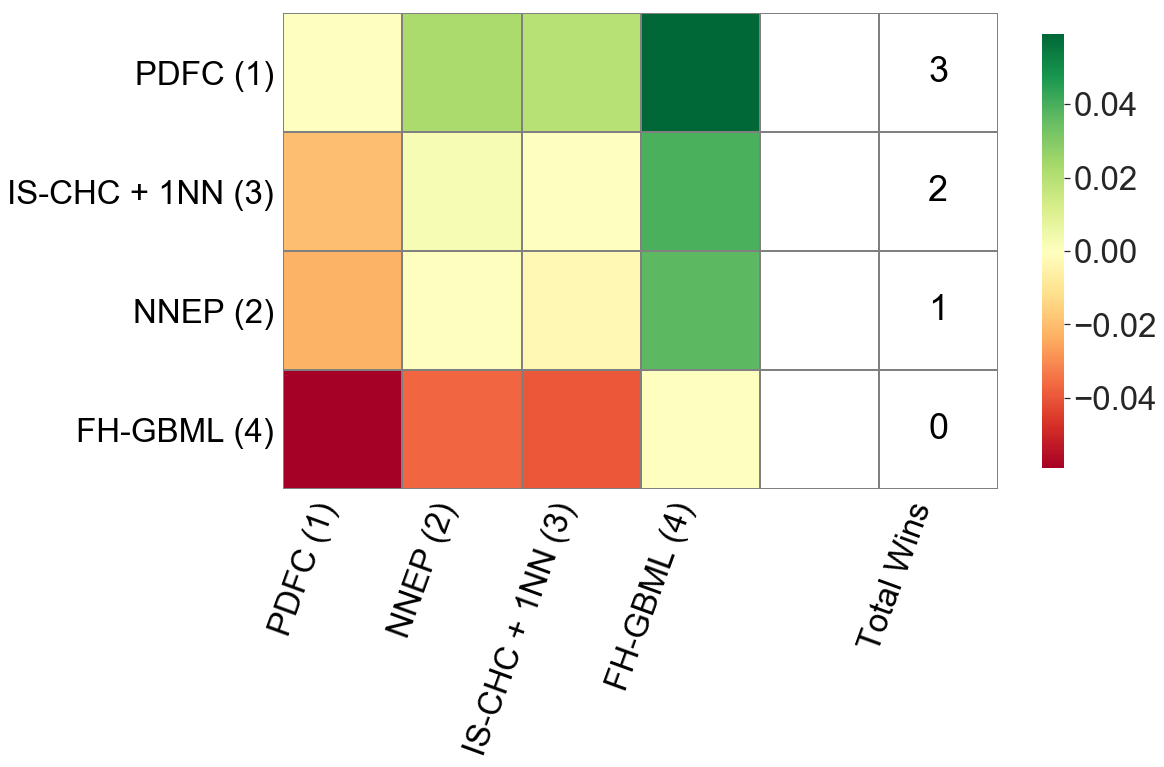

In [9]:
from matplotlib.collections import QuadMesh
from matplotlib.text import Text
    
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper")
sns.set(font_scale=3)



heatmap_df = cem_matrix.copy()

heatmap_df[' '] = 0
heatmap_df['Total Wins'] = (cem_matrix > 0).sum(axis=1)
heatmap_df = heatmap_df.sort_values('Total Wins', ascending=False)

labels = []
for x in heatmap_df['Total Wins'].values:
    tmp = ['' for _ in range(heatmap_df.shape[0])] + ['', '{}'.format(x)]
    labels.append(tmp)
labels = np.array(labels)

fig, ax = plt.subplots(1, 1, figsize=(16, 16))

cmap = plt.get_cmap("RdYlGn")
sns.heatmap(heatmap_df, annot=labels, fmt='', linewidths=1, vmin=cem_matrix.values.min(), vmax=cem_matrix.values.max(),
            linecolor='grey', cmap=cmap, square=True, cbar_kws={"shrink": .5})

# find your QuadMesh object and get array of colors
quadmesh = ax.findobj(QuadMesh)[0]
facecolors = quadmesh.get_facecolors()

# make colors of the last column white
facecolors[np.arange(heatmap_df.shape[1]-1, heatmap_df.shape[0]*heatmap_df.shape[1], heatmap_df.shape[1])] = np.array([1,1,1,1])
facecolors[np.arange(heatmap_df.shape[1]-2, heatmap_df.shape[0]*heatmap_df.shape[1], heatmap_df.shape[1])] = np.array([1,1,1,1])

# set modified colors
quadmesh.set_facecolors = facecolors

# set color of all text to black
for i in ax.findobj(Text):
    i.set_color('black')

plt.xticks(rotation=70, ha='right')
plt.show()

In [65]:
cem_matrix

,PDFC (1),NNEP (2),IS-CHC + 1NN (3),FH-GBML (4)
PDFC (1),0.00000,0.02250,0.01975,0.05925
NNEP (2),-0.02250,0.00000,-0.00275,0.03675
IS-CHC + 1NN (3),-0.01975,0.00275,0.00000,0.03950
FH-GBML (4),-0.05925,-0.03675,-0.03950,0.00000


-0.05925

In [68]:
cem_matrix.values.max()

0.05925